In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [2]:
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import sklearn.metrics as metrics
from copy import deepcopy
from collections import Counter
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, \
    GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.tree import export_graphviz
from graphviz import Source
from random import randint


### Used Functions

In [10]:
def string_to_timestamp(date_string):  
    '''
    Function coverting a time string to a float timestamp
    '''
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)


def create_initial_dataset():
    '''
    Function constructing the dataset from the initial csv file, keeping the categorical data
    '''
    src = 'data_for_student_case.csv'
    ah = open(src, 'r')
    x_labeled = []
    data = []
    conversion_dict = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP': 1.13355} 
    ah.readline()  # skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9] == 'Refused':  # skip Refused transactions
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        issuercountry = line_ah.strip().split(',')[2]  # country code
        txvariantcode = line_ah.strip().split(',')[3]  # type of card: visa/master
        issuer_id = float(line_ah.strip().split(',')[4])  # bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])  # transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        amount = conversion_dict[currencycode] * amount  # currency conversion
        shoppercountry = line_ah.strip().split(',')[7]  # country code
        interaction = line_ah.strip().split(',')[8]  # online transaction or subscription
        label  = 1 if line_ah.strip().split(',')[9] == 'Chargeback' else 0
        verification = line_ah.strip().split(',')[10]  # shopper provide CVC code or not
        cvcresponse = int(line_ah.strip().split(',')[11])  # 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if cvcresponse > 2:
            cvcresponse = 3
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info) + '-' + str(month_info) + '-' + str(day_info)  # Date of transaction
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])  # Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]  # merchant’s webshop
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email', '')))  # mail
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip', '')))  # ip
        card_id = int(float(line_ah.strip().split(',')[16].replace('card', '')))  # card
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                     shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                     accountcode, mail_id, ip_id, card_id, label, creationdate])  # add the interested features here
    data = sorted(data, key=lambda k: k[-1])
    for item in data:  # split data into x,y
        x_labeled.append(item[0:-1])
    df = pd.DataFrame(x_labeled)
    df.columns = ['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode',
                  'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp',
                  'accountcode', 'mail_id', 'ip_id', 'card_id', 'labels']  # column names of the dataset
    df.to_csv('data_for_plots.csv')
    
    
def create_dataset():
    """
    Create the dataset for the bonus part from the original csv file
    """
    src = 'data_for_student_case.csv'
    ah = open(src, 'r')
    x = []  # contains features
    y = []  # contains labels
    data = []
    color = []
    conversion_dict = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP': 1.13355}
    (issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
     verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
    (issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
     verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]

    ah.readline()  # skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9] == 'Refused':  # remove the row with 'refused' label, since it's uncertain about fraud
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])  # date reported flaud
        issuercountry = line_ah.strip().split(',')[2]  # country code
        issuercountry_set.add(issuercountry)
        txvariantcode = line_ah.strip().split(',')[3]  # type of card: visa/master
        txvariantcode_set.add(txvariantcode)
        issuer_id = float(line_ah.strip().split(',')[4])  # bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])  # transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        currencycode_set.add(currencycode)
        amount = conversion_dict[currencycode] * amount  # currency conversion
        shoppercountry = line_ah.strip().split(',')[7]  # country code
        shoppercountry_set.add(shoppercountry)
        interaction = line_ah.strip().split(',')[8]  # online transaction or subscription
        interaction_set.add(interaction)
        if line_ah.strip().split(',')[9] == 'Chargeback':
            label = 1  # label fraud
        else:
            label = 0  # label save
        verification = line_ah.strip().split(',')[10]  # shopper provide CVC code or not
        verification_set.add(verification)
        cvcresponse = int(line_ah.strip().split(',')[11])  # 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if cvcresponse > 2:
            cvcresponse = 3
        crd = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S')
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info) + '-' + str(month_info) + '-' + str(day_info)  # Date of transaction
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])  # Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]  # merchant’s webshop
        accountcode_set.add(accountcode)
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email', '')))  # mail
        mail_id_set.add(mail_id)
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip', '')))  # ip
        ip_id_set.add(ip_id)
        card_id = int(float(line_ah.strip().split(',')[16].replace('card', '')))  # card
        card_id_set.add(card_id)
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                     shoppercountry, interaction, verification, cvcresponse, crd,
                     accountcode, mail_id, ip_id, card_id, label, creationdate])  # add the interested features here

    data = sorted(data, key=lambda k: k[9])  # data sorted according to transaction-time stamp

    for item in data:  # split data into x,y
        x.append(item[0:-2])
        y.append(item[-2])

    # map number to each categorial feature
    for item in list(issuercountry_set):
        issuercountry_dict[item] = list(issuercountry_set).index(item)
    for item in list(txvariantcode_set):
        txvariantcode_dict[item] = list(txvariantcode_set).index(item)
    for item in list(currencycode_set):
        currencycode_dict[item] = list(currencycode_set).index(item)
    for item in list(shoppercountry_set):
        shoppercountry_dict[item] = list(shoppercountry_set).index(item)
    for item in list(interaction_set):
        interaction_dict[item] = list(interaction_set).index(item)
    for item in list(verification_set):
        verification_dict[item] = list(verification_set).index(item)
    for item in list(accountcode_set):
        accountcode_dict[item] = list(accountcode_set).index(item)

    # modify categorial feature to number in data set
    for item in x:
        item[0] = issuercountry_dict[item[0]]
        item[1] = txvariantcode_dict[item[1]]
        item[4] = currencycode_dict[item[4]]
        item[5] = shoppercountry_dict[item[5]]
        item[6] = interaction_dict[item[6]]
        item[7] = verification_dict[item[7]]
        item[10] = accountcode_dict[item[10]]

    # The "original_data_for_aggr.csv" numeric dataset
    # used to compute the aggregated features is created
    des = 'original_data_for_aggr.csv'
    ch_dfa = open(des, 'w')

    ch_dfa.write(
        'issuercountry,txvariantcode,issuer_id,amount,currencycode,shoppercountry,interaction,verification,cvcresponse,'
        'creationdate,accountcode,mail_id,ip_id,card_id,label')
    ch_dfa.write('\n')

    sentence = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            sentence.append(str(x[i][j]))
        sentence.append(str(y[i]))
        ch_dfa.write(','.join(sentence))
        ch_dfa.write('\n')
        sentence = []
        ch_dfa.flush()
    
    
def make_boxplot(data):
    '''
    Function for the visualization task - Boxplot about the accountcode-to-amount feature relationship
    '''
    ax = sns.boxplot(x="accountcode", y="amount", hue="labels", data=data,
                palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"])
    plt.xlabel("Merchant's webshop")
    plt.ylabel("Amount in euros")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_accountcode_amount.png')
    print('boxplot created')

    
def make_boxplot_money(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-amount relationship
    '''
    ax = sns.boxplot(x="labels", y="amount", data=data,
                palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("Amount in euros")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_amount.png')
    print('boxplot created')

    
def make_barplot(data):
    '''
    Function for the visualization task - Barplot about the percentage of cvcresponce code per class 
    '''
    cvc_counts = (data.groupby(['labels'])['cvcresponse'].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index().sort_values('cvcresponse'))
    ax = sns.barplot(x='cvcresponse', y='percentage', data=cvc_counts, hue='labels',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"], loc='upper right')
    plt.xlabel("CVC code")
    plt.ylabel("Percentage of occurrences")
    plt.grid()
    plt.show()
#     plt.savefig('plots/barplot_cvc.png')
    print('barplot created')


def make_barplot_issued(data):
    '''
    Function for the visualization task - Barplot about the percentage of issuercountry code per class 
    '''
    cvc_counts = (data.groupby(['labels'])['issuercountry'].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index())
    ax = sns.barplot(x='issuercountry', y='percentage', data=cvc_counts, hue='labels',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"], loc='upper right')
    ax.set(xlim=(-0.5, 15.5))
    plt.xlabel("Issuer Country")
    plt.ylabel("Percentage of occurrences")
    plt.grid()
    plt.show()
#     plt.savefig('plots/barplot_issuer.png')
    print('barplot created')


def make_boxplot_card_type(data):
    '''
    Function for the visualization task - Boxplot about the amount-to-card type feature relationship
    '''
    ax = sns.boxplot(x="amount", y="txvariantcode", hue="labels", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["benign", "fraudulent"])
    plt.xlabel("Amount in euros")
    plt.ylabel("Type of card")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_card_type.png')
    print('boxplot created')


def make_boxplot_issuer_id(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-issuer id relationship
    '''
    ax = sns.boxplot(x="labels", y="issuer_id", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("Card issuer identifier")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_issuer_id.png')
    print('boxplot created')


def make_boxplot_ip(data):
    '''
    Function for the visualization task - Boxplot about the labels-to-ip id relationship
    '''
    ax = sns.boxplot(x="labels", y="ip_id", data=data,
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']}, sym="")
    ax.set_xticklabels(['benign', 'fraudulent'])
    plt.ylabel("IP address")
    plt.grid()
    plt.show()
#     plt.savefig('plots/boxplot_labels_ip.png')
    print('boxplot created')

    
def plot_roc(fpr, tpr, roc_auc, fpr_smote, tpr_smote, roc_auc_smote, clf_name):
    '''
    Function for the imbalance task - Plots the ROC curve for both the SMOTEd and unSMOTEd classifier
    '''
    plt.figure()
    plt.title('{} - Receiver Operating Characteristic'.format(clf_name))
    plt.plot(fpr, tpr, 'r', label='AUC unSMOTEd = %0.2f' % roc_auc)
    plt.plot(fpr_smote, tpr_smote, 'g', label='AUC SMOTEd = %0.2f' % roc_auc_smote)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
#     plt.savefig('imbalance_plots/{}_ROC.png'.format(clf_name), bbox_inches='tight')
    

def plot_confusion_matrix(y_true, y_pred, clf_name, classes, smote, normalize=False, title=None, cmap=plt.cm.Blues):
    '''
    Function for the imbalance task - Plots the confusion matrix of a classifier 
    '''
    if not title:
        if normalize:  # check if the normalized confusion matrix is to be plotted
            title = '{} - Normalized confusion matrix'.format(clf_name+smote)
        else:
            title = '{} - Confusion matrix, without normalization'.format(clf_name+smote)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
#     fig.savefig('imbalance_plots/{}_confusion.png'.format(clf_name+smote))
    return ax


def plot_prec_rec(precision, recall, precision_smote, recall_smote):
    '''
    Function for the imbalance task - Plots the Precision-Recall curve for both the SMOTEd and unSMOTEd classifier
    '''
    plt.figure()
    plt.title('{} - Precision-recall curve'.format(clf_name))
    plt.plot(recall, precision, 'r', label='Precision-recall UnSMOTEd')
    plt.plot(recall_smote, precision_smote, 'g', label='Precision-recall SMOTEd')
    plt.legend(loc='upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
#     plt.savefig('imbalance_plots/{}_Prec_Rec.png'.format(clf_name), bbox_inches='tight')
    
    
def plot_decision_tree(clf):
    '''
    Function for the classification task - Plots the structure of the trained decision tree
    '''
    features = np.array(['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode',
                         'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp',
                         'accountcode', 'mail_id', 'ip_id', 'card_id'])
    fearure_nums = [0, 4, 5, 8, 10, 12]  # features to be used
    graph = Source(export_graphviz(clf, out_file=None, max_depth=3, feature_names=features[fearure_nums],
                    class_names=['benign', 'fraudulent'], filled=True, rounded=True, special_characters=True,
                    proportion=False, precision=2))
    png_bytes = graph.pipe(format='png')
    with open('dtree.png', 'wb') as f:
        f.write(png_bytes)
    

def make_clf_SMOTE(usx, usy, clf, clf_name, normalize=False, smoted=False):
    '''
    Function for the imbalance task - Trains and tests the classifier clf using 10-fold cross-validation
    If normalize flag is True then the data are being normalised
    If smoted flag is True then SMOTE is used to oversample the minority class 
    '''
    print('----------{}----------'.format(clf_name))
    totalTP, totalFP, totalFN, totalTN = 0, 0, 0, 0
    total_y_test = []
    total_y_prob = []
    total_y_pred = []
    skf = StratifiedKFold(n_splits=10)  # 10-fold stratified cross validation
    for train_index, test_index in skf.split(usx, usy):
        x_train, x_test = usx[train_index], usx[test_index]
        y_train, y_test = usy[train_index], usy[test_index]

        if smoted:  # SMOTE applied
            sm = SMOTE(sampling_strategy=0.5)
            x_train, y_train = sm.fit_resample(x_train, y_train)

        if normalize: # normalization applied
            scaler = RobustScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

        clf.fit(x_train, y_train)  # training of the classifier
        y_predict = clf.predict(x_test)  # testing the classifier
        y_proba = clf.predict_proba(x_test)  # class-wise probabilities of each test sample
        # needed for roc curve
        total_y_test += list(y_test)
        total_y_prob += list(y_proba[:, 1])
        total_y_pred += list(y_predict)

        for i in range(len(y_predict)):
            if y_predict[i] and y_proba[i, 1] <= 0.65:   # adding more "cost" to the misclassification in the fraudulent class
                y_predict[i] = 0
        for i in range(len(y_predict)):
            if y_test[i] and y_predict[i]:
                totalTP += 1
            if not y_test[i] and y_predict[i]:
                totalFP += 1
            if y_test[i] and not y_predict[i]:
                totalFN += 1
            if not y_test[i] and not y_predict[i]:
                totalTN += 1

    print('TOTAL TP: ' + str(totalTP))
    print('TOTAL FP: ' + str(totalFP))
    print('TOTAL FN: ' + str(totalFN))
    print('TOTAL TN: ' + str(totalTN))

    total_y_test = np.array(total_y_test)
    total_y_prob = np.array(total_y_prob)
    total_y_pred = np.array(total_y_pred)
    fpr, tpr, _ = metrics.roc_curve(total_y_test, total_y_prob)  # create FPR ans TPR values for the ROC curve plotting
    precision, recall, _ = precision_recall_curve(total_y_test, total_y_prob)
    roc_auc = metrics.auc(fpr, tpr)  # Area under curve calculation
    if smoted:
        plot_confusion_matrix(total_y_test, total_y_pred, clf_name, ['benign', 'fraudulent'], ' SMOTEd',
                            normalize=True, title=None, cmap=plt.cm.Blues)
    else:
        plot_confusion_matrix(total_y_test, total_y_pred, clf_name, ['benign', 'fraudulent'], '',
                              normalize=True, title=None, cmap=plt.cm.Blues)
    return fpr, tpr, roc_auc, precision, recall


def make_clf(usx, usy, clf, clf_name, sampling, normalize=False):
    '''
    Function for the classification task - Trains and tests the classifier clf using 10-fold cross-validation
    If normalize flag is True then the data are being normalised
    The sampling parameter sets the type of sampling to be used
    '''
    print('----------{} with {}----------'.format(clf_name, sampling))
    totalTP, totalFP, totalFN, totalTN = 0, 0, 0, 0
    plot_ind = randint(0, 9)
    j = 0
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(usx, usy):
        x_train, x_test = usx[train_index], usx[test_index]
        y_train, y_test = usy[train_index], usy[test_index]
        
        # sampling applied
        if sampling == 'SMOTE':
            x_train, y_train = SMOTE(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'ADASYN':
            x_train, y_train = ADASYN(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'ENN':
            x_train, y_train = EditedNearestNeighbours().fit_resample(x_train, y_train)
        elif sampling == 'Tomek':
            x_train, y_train = TomekLinks().fit_resample(x_train, y_train)
        elif sampling == 'SMOTETomek':
            x_train, y_train = SMOTETomek(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'SMOTEENN':
            x_train, y_train = SMOTEENN(sampling_strategy=0.3).fit_resample(x_train, y_train)
        elif sampling == 'NCR':
            x_train, y_train = NeighbourhoodCleaningRule().fit_resample(x_train, y_train)
        elif sampling == 'OSS':
            x_train, y_train = OneSidedSelection().fit_resample(x_train, y_train)

        if normalize:
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

        clf.fit(x_train, y_train)
        
        # Decision tree plot for the white-box algorithm needs
        # if plot_ind == j and clf_name == 'DecisionTreeClassifier':
        #     plot_decision_tree(clf)

        y_predict = clf.predict(x_test)

        for i in range(len(y_predict)):
            if y_test[i] and y_predict[i]:
                totalTP += 1
            if not y_test[i] and y_predict[i]:
                totalFP += 1
            if y_test[i] and not y_predict[i]:
                totalFN += 1
            if not y_test[i] and not y_predict[i]:
                totalTN += 1
        j += 1

    print('TOTAL TP: ' + str(totalTP))
    print('TOTAL FP: ' + str(totalFP))
    print('TOTAL FN: ' + str(totalFN))
    print('TOTAL TN: ' + str(totalTN))
    
    
def make_clf_bonus(usx, usy, clf, clf_name, strategy='SMOTE', normalize=False, cutoff=0.5):
    """
    Makes classification with the given parameters and print the results
    :param usx: features
    :param usy: labels
    :param clf: classifier
    :param clf_name: name of the classifier
    :param strategy: sampling strategy to be used
    :param normalize: boolean to decide whether to normilize or not
    :param cutoff: cutoff value for the classification threshold
    :return:
    """
    print('----------{0} with {1}----------'.format(clf_name, strategy))
    totalTP, totalFP, totalFN, totalTN = 0, 0, 0, 0
    total_y_test = []
    total_y_prob = []
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(usx, usy):
        x_train, x_test = usx[train_index], usx[test_index]
        y_train, y_test = usy[train_index], usy[test_index]

        # select sampling strategy
        if strategy == 'SMOTE':
            sm = SMOTE(sampling_strategy=0.5, n_jobs=-1)
            x_train, y_train = sm.fit_resample(x_train, y_train)
        elif strategy == 'ADASYN':
            ad = ADASYN(n_jobs=-1)
            x_train, y_train = ad.fit_resample(x_train, y_train)
        elif strategy == 'ENN':
            en = EditedNearestNeighbours(n_jobs=-1)
            x_train, y_train = en.fit_resample(x_train, y_train)
        elif strategy == 'TL':
            tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
            x_train, y_train = tl.fit_resample(x_train, y_train)
        elif strategy == 'OSS':
            oss = OneSidedSelection(n_jobs=-1)
            x_train, y_train = oss.fit_resample(x_train, y_train)
        elif strategy == 'SMOTEK':
            sm = SMOTETomek(smote=SMOTE(sampling_strategy=0.5, n_jobs=-1), tomek=TomekLinks(n_jobs=-1))
            x_train, y_train = sm.fit_resample(x_train, y_train)
        elif strategy == 'SMOTEEN':
            smoteenn = SMOTEENN(smote=SMOTE(sampling_strategy=0.5, n_jobs=-1), enn=EditedNearestNeighbours(n_jobs=-1))
            x_train, y_train = smoteenn.fit_resample(x_train, y_train)

        # normalize data if needed
        if normalize:
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

        # fit classifier
        clf.fit(x_train, y_train)

        # predict labels and their probaility
        y_predict = clf.predict(x_test)
        y_predict_proba = clf.predict_proba(x_test)

        total_y_test += list(y_test)
        total_y_prob += list(y_predict_proba[:, 1])

        # modify the threshold for the two classes
        if cutoff < 0.5:
            for i in range(len(y_predict)):
                if y_predict[i] == 0 and y_predict_proba[i, 1] >= cutoff:
                    y_predict[i] = 1
        elif cutoff > 0.5:
            for i in range(len(y_predict)):
                if y_predict[i] == 1 and y_predict_proba[i, 1] <= cutoff:
                    y_predict[i] = 0

        TP, FP, FN, TN = 0, 0, 0, 0

        for i in range(len(y_predict)):
            if y_test[i] == 1 and y_predict[i] == 1:
                TP += 1
            if y_test[i] == 0 and y_predict[i] == 1:
                FP += 1
            if y_test[i] == 1 and y_predict[i] == 0:
                FN += 1
            if y_test[i] == 0 and y_predict[i] == 0:
                TN += 1
        totalFN += FN
        totalFP += FP
        totalTN += TN
        totalTP += TP

    print('TOTAL TP: ' + str(totalTP))
    print('TOTAL FP: ' + str(totalFP))
    print('TOTAL FN: ' + str(totalFN))
    print('TOTAL TN: ' + str(totalTN))
    
    
# Below there are the functions that are used for the aggregated features
def custom_aggr(cols, d):
    l = 0
    ids = cols['card_id']
    creationdate = cols['creationdate']
    for id, crd in zip(ids, creationdate):
        l += len([v for v in d[id] if 0 <= (crd - v).days <= 30]) - 1
    return l


def custom_aggr_am_per_trans(cols, d_crd, d_am):
    l = 0
    ids = cols['card_id']
    creationdate = cols['creationdate']
    euroamount = cols['EuroAmount']
    for id, crd, em in zip(ids, creationdate, euroamount):
        l += np.mean([v for i, v in enumerate(d_am[id]) if 0 <= (crd - d_crd[id][i]).days <= 30])
    return int(round(l))


def custom_aggr_avg_over_3_mon(cols, d_crd, d_am):
    l = 0
    ids = cols['card_id']
    creationdate = cols['creationdate']
    euroamount = cols['EuroAmount']
    for id, crd, em in zip(ids, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[id]) if 0 <= (crd - d_crd[id][i]).days <= 90])
    l = int(round(l / 12))
    return l


def custom_aggr_avg_daily_over_month(cols, d_crd, d_am):
    l = 0
    ids = cols['card_id']
    creationdate = cols['creationdate']
    euroamount = cols['EuroAmount']
    for id, crd, em in zip(ids, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[id]) if 0 <= (crd - d_crd[id][i]).days <= 30])
    l = int(round(l / 30))
    return l


def custom_aggr_amount_merchant_over_month(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for cid, acc, crd, em in zip(card_id, accountcode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[(cid, acc)]) if 0 <= (crd - d_crd[(cid, acc)][i]).days <= 30]) - em
    l = int(round(l / 30))
    return l


def custom_aggr_diff_merchant_over_month(cols, d_crd):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for cid, acc, crd, em in zip(card_id, accountcode, creationdate, euroamount):
        l += len([v for v in d_crd[(cid, acc)] if 0 <= (crd - v).days <= 30]) - 1
    return int(round(l))


def custom_aggr_amount_merchant_over_3_months(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for cid, acc, crd, em in zip(card_id, accountcode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[(cid, acc)]) if 0 <= (crd - d_crd[(cid, acc)][i]).days <= 90]) - em
    l = int(round(l / 12))
    return l


def custom_aggr_amount_same_day(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    creationdate = cols['creationdate']
    for cid, crd, em in zip(card_id, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[cid]) if crd.date() == d_crd[cid][i].date()]) - em
    return l


def custom_aggr_number_same_day(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    creationdate = cols['creationdate']
    for cid, crd in zip(card_id, creationdate):
        l += len([v for i, v in enumerate(d_am[cid]) if crd.date() == d_crd[cid][i].date()]) - 1
    return l


def custom_aggr_amount_same_merchant(cols, d_crd, d_am):
    l = 0
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    d_am = np.array(d_am)
    for acc, crd, em in zip(accountcode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[acc]) if 0 <= (crd - d_crd[acc][i]).days <= 30]) - em
        # l += np.sum([(d_am[list(map(lambda x: 0 <= (crd - x).days <= 30, d_crd[acc]))])]) - em
    l = int(round(l / 30))
    return l


def custom_aggr_num_same_merchant(cols, d_crd):
    l = 0
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for acc, crd, em in zip(accountcode, creationdate, euroamount):
        l += len([v for v in d_crd[acc] if 0 <= (crd - v).days <= 30]) - 1
    return int(round(l-1))


def custom_aggr_amount_currency_over_month(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    currencycode = cols['currencycode']
    creationdate = cols['creationdate']
    for cid, cur, crd, em in zip(card_id, currencycode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[(cid, cur)]) if 0 <= (crd - d_crd[(cid, cur)][i]).days <= 30]) - em
    l = int(round(l / 30))
    return l


def custom_aggr_diff_currency_over_month(cols, d_crd):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    currencycode = cols['currencycode']
    creationdate = cols['creationdate']
    for cid, cur, crd, em in zip(card_id, currencycode, creationdate, euroamount):
        l += len([v for v in d_crd[(cid, cur)] if 0 <= (crd - v).days <= 30]) - 1
    return int(round(l))


def custom_aggr_amount_country_over_month(cols, d_crd, d_am):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    shoppercountrycode = cols['shoppercountrycode']
    creationdate = cols['creationdate']
    for cid, shc, crd, em in zip(card_id, shoppercountrycode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[(cid, shc)]) if 0 <= (crd - d_crd[(cid, shc)][i]).days <= 30]) - em
    l = int(round(l / 30))
    return l


def custom_aggr_diff_country_over_month(cols, d_crd):
    l = 0
    card_id = cols['card_id']
    euroamount = cols['EuroAmount']
    shoppercountrycode = cols['shoppercountrycode']
    creationdate = cols['creationdate']
    for cid, shc, crd, em in zip(card_id, shoppercountrycode, creationdate, euroamount):
        l += len([v for v in d_crd[(cid, shc)] if 0 <= (crd - v).days <= 30]) - 1
    return int(round(l))


def custom_aggr_amount_merchant_type_over_3_months(cols, d_crd, d_am):
    l = 0
    euroamount = cols['EuroAmount']
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for acc, crd, em in zip(accountcode, creationdate, euroamount):
        l += np.sum([v for i, v in enumerate(d_am[acc]) if 0 <= (crd - d_crd[acc][i]).days <= 90]) - em
    l = int(round(l / 12))
    return l


def custom_aggr_diff_merchant_type_over_3_months(cols, d_crd):
    l = 0
    accountcode = cols['accountcode']
    creationdate = cols['creationdate']
    for acc, crd in zip(accountcode, creationdate):
        l += len([v for v in d_crd[acc] if 0 <= (crd - v).days <= 90]) - 1
    l = int(round(l))
    return l


def aggregate_data(data):
    """
    Computes the aggregated features
    :param data: original dataset
    :return: dataset with aggregated features
    """
    gen = data[['card_id', 'creationdate', 'EuroAmount', 'txvariantcode', 'accountcode', 'shoppercountrycode', 'currencycode']]

    # number of transactions on the last month
    trans_over_month = data[['card_id', 'creationdate']]
    d1 = gen.groupby('card_id')['creationdate'].apply(list).to_dict()
    trans_over_month = trans_over_month.groupby(['card_id', 'creationdate'], as_index=False)[['card_id', 'creationdate']].agg(custom_aggr, d1).to_frame('trans_past_month')
    data = pd.merge(data, trans_over_month, how='inner', on=['card_id', 'creationdate'])

    # amount spent on the transactions of the last month
    amount_per_trans = data[['card_id', 'EuroAmount', 'creationdate']]
    d2 = gen.groupby('card_id')['EuroAmount'].apply(list).to_dict()
    amount_per_trans = amount_per_trans.groupby(['card_id', 'EuroAmount', 'creationdate'], as_index=False)['card_id', 'EuroAmount', 'creationdate'].agg(custom_aggr_am_per_trans, d1, d2).to_frame('avg_amount_per_trans')
    data = pd.merge(data, amount_per_trans, how='inner', on=['card_id', 'creationdate'])

    # average amount spent over last 3 months
    avg_over_3_mon = data[['card_id', 'EuroAmount', 'creationdate']]
    avg_over_3_mon = avg_over_3_mon.groupby(['card_id', 'EuroAmount', 'creationdate'], as_index=False)[['card_id', 'EuroAmount', 'creationdate']].agg(custom_aggr_avg_over_3_mon, d1, d2).to_frame('avg_over_3_mon')
    data = pd.merge(data, avg_over_3_mon, how='inner', on=['card_id', 'creationdate'])

    # average daily amount spent over last month
    avg_daily_over_month = data[['card_id', 'EuroAmount', 'creationdate']]
    avg_daily_over_month = avg_daily_over_month.groupby(['card_id', 'EuroAmount', 'creationdate'], as_index=False)['card_id', 'EuroAmount', 'creationdate'].agg(custom_aggr_avg_daily_over_month, d1, d2).to_frame('avg_daily_over_month')
    data = pd.merge(data, avg_daily_over_month, how='inner', on=['card_id', 'creationdate'])

    # average daily amount spent over last month
    amount_merchant_over_month = data[['card_id', 'accountcode', 'creationdate','EuroAmount']]
    d3 = gen.groupby(['card_id', 'accountcode'])['creationdate'].apply(list).to_dict()
    d4 = gen.groupby(['card_id', 'accountcode'])['EuroAmount'].apply(list).to_dict()
    amount_merchant_over_month = amount_merchant_over_month.groupby(['card_id', 'accountcode', 'creationdate', 'EuroAmount'], as_index=False)['card_id', 'accountcode', 'creationdate', 'EuroAmount'].agg(custom_aggr_amount_merchant_over_month, d3, d4).to_frame('amount_merchant_over_month')
    data = pd.merge(data, amount_merchant_over_month, how='inner', on=['card_id', 'accountcode', 'creationdate', 'EuroAmount'])

    # number of different merchant over the last month
    diff_merchant_over_month = data[['card_id', 'accountcode', 'creationdate','EuroAmount']]
    diff_merchant_over_month = diff_merchant_over_month.groupby(['card_id', 'accountcode', 'creationdate','EuroAmount'], as_index=False)['card_id', 'accountcode', 'creationdate','EuroAmount'].agg(custom_aggr_diff_merchant_over_month, d3).to_frame('diff_merchant_over_month')
    data = pd.merge(data, diff_merchant_over_month, how='inner', on=['card_id', 'accountcode', 'creationdate','EuroAmount'])

    # amount spent the last 3 month one this merchant
    amount_merchant_over_3_months = data[['card_id', 'EuroAmount', 'accountcode', 'creationdate']]
    amount_merchant_over_3_months = \
    amount_merchant_over_3_months.groupby(['card_id', 'EuroAmount', 'accountcode', 'creationdate'], as_index=False).agg(custom_aggr_amount_merchant_over_3_months, d3, d4).to_frame('amount_merchant_over_3_months')
    data = pd.merge(data, amount_merchant_over_3_months, how='inner', on=['card_id', 'EuroAmount', 'accountcode', 'creationdate'])

    # amount spent by this card the same day as the one of the transaction
    amount_same_day = data[['card_id', 'creationdate', 'EuroAmount']]
    amount_same_day = amount_same_day.groupby(['card_id', 'creationdate', 'EuroAmount'], as_index=False)['card_id', 'creationdate', 'EuroAmount'].agg(custom_aggr_amount_same_day,d1, d2).to_frame('amount_same_day')
    data = pd.merge(data, amount_same_day, how='inner', on=['card_id', 'creationdate', 'EuroAmount'])

    # number of trancactions done the same day by this card
    number_same_day = data[['card_id', 'creationdate']]
    number_same_day = number_same_day.groupby(['card_id', 'creationdate'], as_index=False)['card_id', 'creationdate'].agg(custom_aggr_number_same_day, d1, d2).to_frame('number_same_day')
    data = pd.merge(data, number_same_day, how='inner', on=['card_id', 'creationdate'])

    # amount spent on this currency over last month by this card
    amount_currency_over_month = data[['card_id', 'currencycode', 'creationdate', 'EuroAmount']]
    d7 = gen.groupby(['card_id', 'currencycode'])['creationdate'].apply(list).to_dict()
    d8 = gen.groupby(['card_id', 'currencycode'])['EuroAmount'].apply(list).to_dict()
    amount_currency_over_month = amount_currency_over_month.groupby(['card_id', 'currencycode', 'creationdate', 'EuroAmount'], as_index=False)['card_id', 'currencycode', 'creationdate', 'EuroAmount'].agg(custom_aggr_amount_currency_over_month, d7,d8).to_frame('amount_currency_over_month')
    data = pd.merge(data, amount_currency_over_month, how='inner', on=['card_id', 'currencycode', 'creationdate', 'EuroAmount'])


    # different currencies used by this card the last month
    diff_currency_over_month = data[['card_id', 'currencycode', 'creationdate', 'EuroAmount']]
    diff_currency_over_month = diff_currency_over_month.groupby(['card_id', 'currencycode', 'creationdate', 'EuroAmount'], as_index=False)['card_id', 'currencycode', 'creationdate', 'EuroAmount'].agg(custom_aggr_diff_currency_over_month,d7).to_frame('diff_currency_over_month')
    data = pd.merge(data, diff_currency_over_month, how='inner', on=['card_id', 'currencycode', 'creationdate', 'EuroAmount'])


    # amount spent on this country over the last month
    amount_country_over_month = data[['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount']]
    d9 = gen.groupby(['card_id', 'shoppercountrycode'])['creationdate'].apply(list).to_dict()
    d10 = gen.groupby(['card_id', 'shoppercountrycode'])['EuroAmount'].apply(list).to_dict()
    amount_country_over_month = amount_country_over_month.groupby(['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'],as_index=False)['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'].agg(custom_aggr_amount_country_over_month,d9, d10).to_frame('amount_country_over_month')
    data = pd.merge(data, amount_country_over_month, how='inner', on=['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'])


    # number of different countries of transactions the last month
    diff_country_over_month = data[['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount']]
    diff_country_over_month = diff_country_over_month.groupby(['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'], as_index=False)['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'].agg(custom_aggr_diff_country_over_month,d9).to_frame('diff_country_over_month')
    data = pd.merge(data, diff_country_over_month, how='inner', on=['card_id', 'shoppercountrycode', 'creationdate', 'EuroAmount'])

    return data


def data_encoding(data, column_name, threshold):
    count = dict(data[column_name].value_counts())
    mapping = {}
    for id in count.keys():
        if count[id] > threshold:
            mapping[id] = id
        else:
            mapping[id] = 'dk'
    data[column_name] = data[column_name].map(mapping)
    return data

### Visualization Task

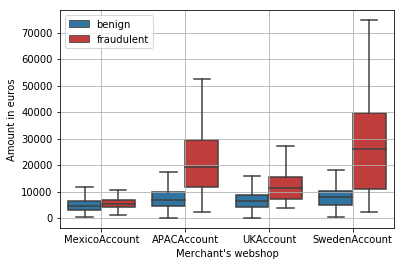

boxplot created


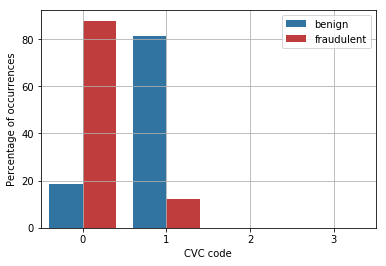

barplot created


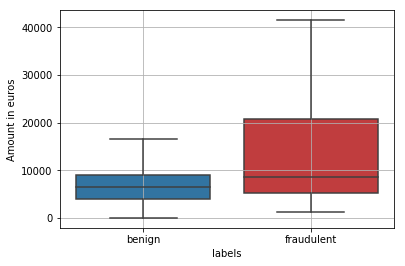

boxplot created


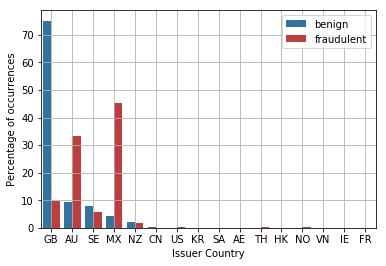

barplot created


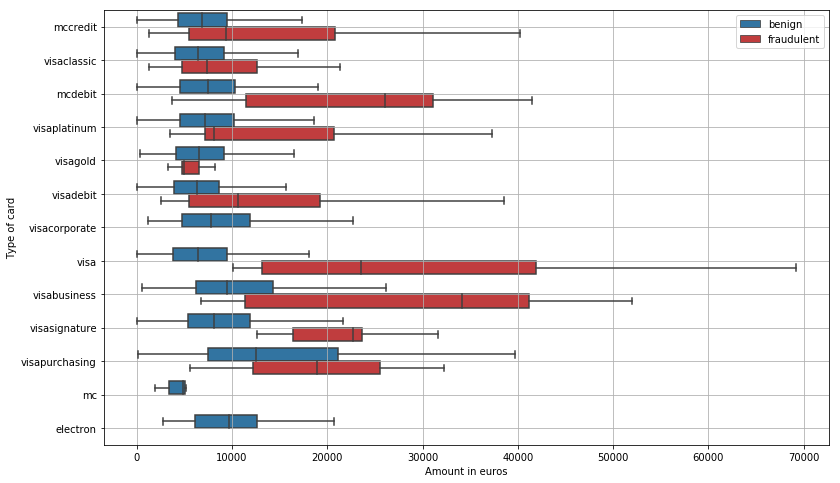

boxplot created


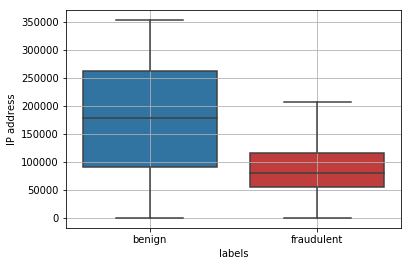

boxplot created


In [4]:
# create_initial_dataset()  # to be used if the "data_for_plots.csv" is not already created
data = pd.read_csv('data_for_plots.csv')
plt.figure()
make_boxplot(data)
plt.figure()
make_barplot(data)
plt.figure()
make_boxplot_money(data)
plt.figure()
make_barplot_issued(data)
plt.figure(figsize=(13, 8))
make_boxplot_card_type(data)
# plt.figure()
# make_boxplot_issuer_id(data)
plt.figure()
make_boxplot_ip(data)

### Numeric dataset creation

In [ ]:
src = 'data_for_student_case.csv'
ah = open(src, 'r')
x = []  # contains features
y = []  # contains labels
data = []
color = []
conversion_dict = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP': 1.13355}
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
 verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
 verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
ah.readline()  # skip first line
for line_ah in ah:
    if line_ah.strip().split(',')[9] == 'Refused':  # remove the row with 'refused' label, since it's uncertain about fraud
        continue
    if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
        continue
    bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])  # date reported flaud
    issuercountry = line_ah.strip().split(',')[2]  # country code
    issuercountry_set.add(issuercountry)
    txvariantcode = line_ah.strip().split(',')[3]  # type of card: visa/master
    txvariantcode_set.add(txvariantcode)
    issuer_id = float(line_ah.strip().split(',')[4])  # bin card issuer identifier
    amount = float(line_ah.strip().split(',')[5])  # transaction amount in minor units
    currencycode = line_ah.strip().split(',')[6]
    currencycode_set.add(currencycode)
    amount = conversion_dict[currencycode] * amount  # currency conversion
    shoppercountry = line_ah.strip().split(',')[7]  # country code
    shoppercountry_set.add(shoppercountry)
    interaction = line_ah.strip().split(',')[8]  # online transaction or subscription
    interaction_set.add(interaction)
    if line_ah.strip().split(',')[9] == 'Chargeback':
        label = 1  # label fraud
    else:
        label = 0  # label save
    verification = line_ah.strip().split(',')[10]  # shopper provide CVC code or not
    verification_set.add(verification)
    cvcresponse = int(line_ah.strip().split(',')[11])  # 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
    if cvcresponse > 2:
        cvcresponse = 3
    year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').year
    month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').month
    day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], '%Y-%m-%d %H:%M:%S').day
    creationdate = str(year_info) + '-' + str(month_info) + '-' + str(day_info)  # Date of transaction
    creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])  # Date of transaction-time stamp
    accountcode = line_ah.strip().split(',')[13]  # merchant’s webshop
    accountcode_set.add(accountcode)
    mail_id = int(float(line_ah.strip().split(',')[14].replace('email', '')))  # mail
    mail_id_set.add(mail_id)
    ip_id = int(float(line_ah.strip().split(',')[15].replace('ip', '')))  # ip
    ip_id_set.add(ip_id)
    card_id = int(float(line_ah.strip().split(',')[16].replace('card', '')))  # card
    card_id_set.add(card_id)
    data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                 shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                 accountcode, mail_id, ip_id, card_id, label, creationdate])  # add the interested features here

data = sorted(data, key=lambda k: k[9])  # data sorted according to transaction-time stamp

for item in data:  # split data into x,y
    x.append(item[0:-2])
    y.append(item[-2])
    
# map number to each categorial feature
for item in list(issuercountry_set):
    issuercountry_dict[item] = list(issuercountry_set).index(item)
for item in list(txvariantcode_set):
    txvariantcode_dict[item] = list(txvariantcode_set).index(item)
for item in list(currencycode_set):
    currencycode_dict[item] = list(currencycode_set).index(item)
for item in list(shoppercountry_set):
    shoppercountry_dict[item] = list(shoppercountry_set).index(item)
for item in list(interaction_set):
    interaction_dict[item] = list(interaction_set).index(item)
for item in list(verification_set):
    verification_dict[item] = list(verification_set).index(item)
for item in list(accountcode_set):
    accountcode_dict[item] = list(accountcode_set).index(item)
# print(len(list(card_id_set)))

# modify categorial feature to number in data set
for item in x:
    item[0] = issuercountry_dict[item[0]]
    item[1] = txvariantcode_dict[item[1]]
    item[4] = currencycode_dict[item[4]]
    item[5] = shoppercountry_dict[item[5]]
    item[6] = interaction_dict[item[6]]
    item[7] = verification_dict[item[7]]
    item[10] = accountcode_dict[item[10]]

# The "original_data.csv" numeric dataset is created
des = 'original_data.csv'
ch_dfa = open(des, 'w')

ch_dfa.write(
    'issuercountry, txvariantcode, issuer_id, amount, currencycode, shoppercountry, interaction, '
    'verification, cvcresponse, creationdate_stamp, accountcode, mail_id, ip_id, card_id, label')
ch_dfa.write('\n')

sentence = []
for i in range(len(x)):
    for j in range(len(x[i])):
        sentence.append(str(x[i][j]))
    sentence.append(str(y[i]))
    ch_dfa.write(','.join(sentence))
    ch_dfa.write('\n')
    sentence = []
    ch_dfa.flush()

### Imbalance Task

----------KNeighborsClassifier----------
TOTAL TP: 10
TOTAL FP: 67
TOTAL FN: 335
TOTAL TN: 236286


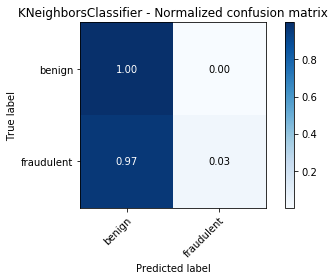

----------KNeighborsClassifier----------
TOTAL TP: 98
TOTAL FP: 7325
TOTAL FN: 247
TOTAL TN: 229028


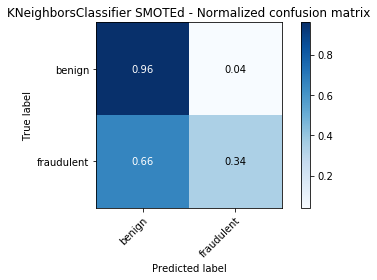

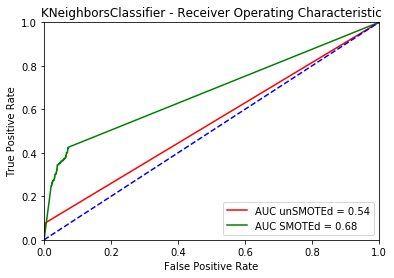

----------LogisticRegression----------
TOTAL TP: 0
TOTAL FP: 2
TOTAL FN: 345
TOTAL TN: 236351


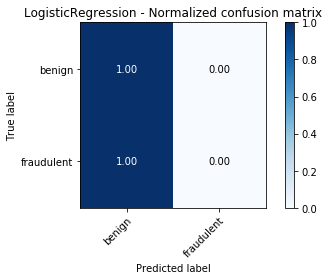

----------LogisticRegression----------


C:\Users\rafai\AppData\Roaming\Python\Python36\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rafai\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


TOTAL TP: 262
TOTAL FP: 14341
TOTAL FN: 83
TOTAL TN: 222012


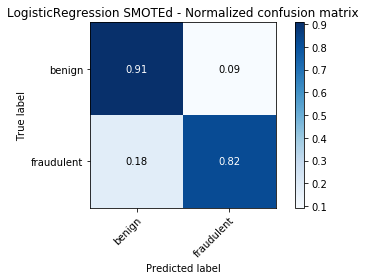

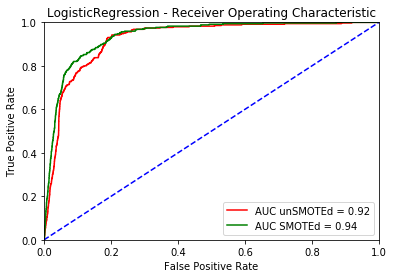

----------AdaBoostClassifier----------
TOTAL TP: 0
TOTAL FP: 0
TOTAL FN: 345
TOTAL TN: 236353


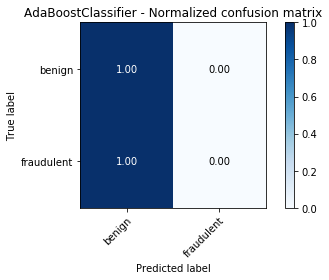

----------AdaBoostClassifier----------
TOTAL TP: 0
TOTAL FP: 0
TOTAL FN: 345
TOTAL TN: 236353


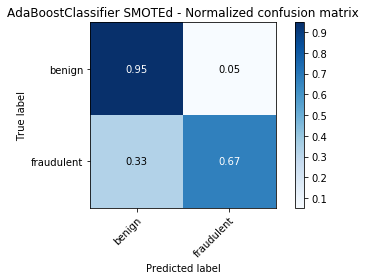

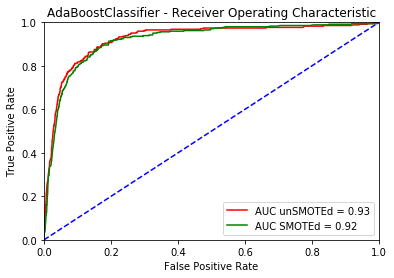

----------RandomForestClassifier----------
TOTAL TP: 2
TOTAL FP: 2
TOTAL FN: 343
TOTAL TN: 236351


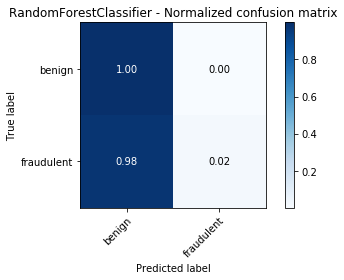

----------RandomForestClassifier----------
TOTAL TP: 27
TOTAL FP: 592
TOTAL FN: 318
TOTAL TN: 235761


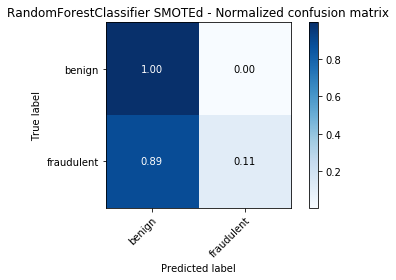

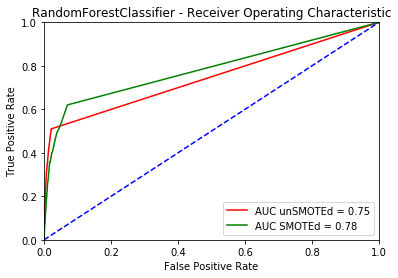

In [5]:
filename = 'original_data.csv'
data = pd.read_csv(filename)
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

x = np.delete(x, [2, 4, 5, 6, 7, 9, 11, 13], 1)  # specific features are kept - selection done mainly according to the 
                                                 #  relationships identified in the visualization part
# dictionary with the tested classifiers
clfs = {'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='auto', weights='distance')
        , 'LogisticRegression': LogisticRegression(solver='newton-cg')
#         , 'NaiveBayes': GaussianNB()
        , 'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50)
        , 'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
#         , 'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100)
#         , 'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100)
#         , 'VotingClassifier': VotingClassifier(estimators=[
#                 ('knn', neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', weights='distance')),
#                 ('lr', LogisticRegression(solver='newton-cg')),
#                 ('gnb', GaussianNB())
#                 ], voting='soft')
        }
for clf_name, clf in clfs.items():  # check all the classifiers both with and without SMOTE 
    usx = np.copy(x)
    usy = np.copy(y)
    if clf_name == 'LogisticRegression':
        fpr, tpr, roc_auc, precision, recall = make_clf_SMOTE(usx, usy, clf, clf_name, normalize=True)
        fpr_smote, tpr_smote, roc_auc_smote, precision_smote, recall_smote = \
            make_clf_SMOTE(usx, usy, clf, clf_name, normalize=True, smoted=True)
    else:
        fpr, tpr, roc_auc, precision, recall = make_clf_SMOTE(usx, usy, clf, clf_name)
        fpr_smote, tpr_smote, roc_auc_smote, precision_smote, recall_smote = \
            make_clf_SMOTE(usx, usy, clf, clf_name, smoted=True)
    plot_roc(fpr, tpr, roc_auc, fpr_smote, tpr_smote, roc_auc_smote, clf_name)
    # plot_prec_rec(precision, recall, precision_smote, recall_smote)

### Classification Task

In [6]:
filename = 'original_data.csv'
data = pd.read_csv(filename)
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

x = np.delete(x, [1, 2, 3, 6, 7, 9, 11, 13], 1)  # specific features are kept 

# dictionaries with the two classifiers to be tested
clfs = {'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', class_weight='balanced')   
        , 'RandomForestClassifier': RandomForestClassifier(n_estimators=50, criterion='entropy',
                                                           class_weight='balanced', n_jobs=-1)  
        }
for smlp in ['SMOTE', 'ADASYN', 'Tomek', 'OSS', 'ENN', 'SMOTETomek', 'SMOTEENN']:  # check different types of sampling
    for clf_name, clf in clfs.items():
        usx = np.copy(x)
        usy = np.copy(y)
        make_clf(usx, usy, clf, clf_name, smlp)

----------DecisionTreeClassifier with SMOTE----------
TOTAL TP: 219
TOTAL FP: 13198
TOTAL FN: 126
TOTAL TN: 223155
----------RandomForestClassifier with SMOTE----------
TOTAL TP: 213
TOTAL FP: 13094
TOTAL FN: 132
TOTAL TN: 223259
----------DecisionTreeClassifier with ADASYN----------
TOTAL TP: 229
TOTAL FP: 13864
TOTAL FN: 116
TOTAL TN: 222489
----------RandomForestClassifier with ADASYN----------
TOTAL TP: 219
TOTAL FP: 13917
TOTAL FN: 126
TOTAL TN: 222436
----------DecisionTreeClassifier with Tomek----------
TOTAL TP: 97
TOTAL FP: 319
TOTAL FN: 248
TOTAL TN: 236034
----------RandomForestClassifier with Tomek----------
TOTAL TP: 93
TOTAL FP: 294
TOTAL FN: 252
TOTAL TN: 236059
----------DecisionTreeClassifier with OSS----------
TOTAL TP: 99
TOTAL FP: 323
TOTAL FN: 246
TOTAL TN: 236030
----------RandomForestClassifier with OSS----------
TOTAL TP: 99
TOTAL FP: 288
TOTAL FN: 246
TOTAL TN: 236065
----------DecisionTreeClassifier with ENN----------
TOTAL TP: 115
TOTAL FP: 625
TOTAL FN: 230


### Bonus Task

In [11]:
# uncomment the following lines to create the dataset. I will take some time !!!
# create_dataset()
# filename = 'original_data_for_aggr.csv'
# data = pd.read_csv(filename)
# data = data.rename(columns={'amount': 'EuroAmount', 'shoppercountry': 'shoppercountrycode'})
#
# # add aggregated features
# data = aggregate_data(deepcopy(data))

# use this to load the aggregated features instead of calculating them again
with open('data_numerical.pickle', 'rb') as handle:
    data = pickle.load(handle)

# keep only useful features
data = data.drop(['txvariantcode', 'EuroAmount', 'interaction','verification', 'creationdate', 'mail_id'], axis=1)

# convert bin to integer
data['bin'] = data.apply(lambda r: int(round(r['issuer_id'])), axis=1)


# encode data
data = data_encoding(deepcopy(data), 'issuer_id', 3)
data = data_encoding(deepcopy(data), 'card_id', 10)

# one-hot encoding
data = pd.get_dummies(data)

# get features and labels
x = data.drop('label', axis=1).values
y = data['label'].values


# apply pca
print('Applying PCA')
pca = PCA(n_components=100)
x = pca.fit_transform(x)
print('PCA done')

# define the classifiers used and their hyperparameters
clfs = {'RandomForestClassifier': RandomForestClassifier(n_estimators=50, criterion='entropy',
                                                         class_weight='balanced', n_jobs=-1),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', class_weight='balanced')}

# make classification
for strategy in ['SMOTE', 'ENN', 'SMOTEEN']:
    for clf_name, clf in clfs.items():
        usx = np.copy(x)
        usy = np.copy(y)
        make_clf_bonus(usx, usy, clf, clf_name, strategy=strategy, cutoff=0.4)

Applying PCA
PCA done
----------RandomForestClassifier with SMOTE----------
TOTAL TP: 94
TOTAL FP: 581
TOTAL FN: 251
TOTAL TN: 235772
----------DecisionTreeClassifier with SMOTE----------


KeyboardInterrupt: 